In [2]:
import pandas
import numpy as np
import matplotlib
from matplotlib import pyplot as plt

matplotlib.rcParams['font.sans-serif'] = ['SimHei']  # 设置中文字体
matplotlib.rcParams['axes.unicode_minus'] = False  # 解决负号显示问题
data = pandas.read_csv("TDOA与PDOA集中上传.csv")
resu = []
rolling = None
resu2 = []
for _,i in data.iterrows():
    if rolling != i['rolling']:
        if len(resu2)>0:
            resu2 = pandas.DataFrame(resu2)
            resu.append(resu2)
        rolling = i['rolling']
        resu2 = []
    resu2.append(i)
del resu2 
del rolling 
del i 
del data

In [3]:
Anchors = [0x0AFC,0x5B2B,0x08D3,0x7BD3] # 从目前收到的anchor里选择.需要保证顺序可控
tag = 0x45AF # 下拉框选择

filtwindow = 10 # 滤波窗口 
ElectLen = 21 # 天线间距
Freq = 6.5e9 # 载波频率
print(Anchors,tag)

[2812, 23339, 2259, 31699] 17839


In [4]:
rolling=[i['rolling'].values[0] for i in resu]
resu2 = []
# 数据按给定的anchor顺序重排
for i in resu:
    data = np.array(i[i['TagID'] == tag])
    resu2.append(np.nan + np.zeros((len(Anchors),6)))
    for j in range(len(Anchors)):
        data = np.array(i[np.logical_and(i['TagID'] == tag,i['AnchorId'] == Anchors[j])])
        if(len(data)==0):continue
        resu2[-1][np.array(Anchors)==Anchors[j],...] = np.reshape(data[None,...],(1,-1))
resu2 = np.concatenate([i[None,...] for i in resu2],0)

In [6]:
resu2.shape
TOA = resu2[:,:,3];
POA_SYNC = resu2[:,:,4];
POA_REPLY = resu2[:,:,5];
POA_SYNC = np.exp(POA_SYNC*2j*np.pi/256);
POA_REPLY = np.exp(POA_REPLY*2j*np.pi/256);

PDOA_SYNC = POA_SYNC*np.conj(POA_SYNC[:,0,None]);
PDOA_REPLY = POA_REPLY*np.conj(POA_REPLY[:,0,None]);
PDOA = PDOA_SYNC+PDOA_REPLY;PDOA=PDOA/np.abs(PDOA);

rolling=np.array(rolling)
temp = np.argsort(rolling)

rolling = rolling[temp]
PDOA = PDOA[temp]

C:\Users\Administrator\AppData\Local\Temp\ipykernel_7060\1351919700.py:10: RuntimeWarning: invalid value encountered in divide
  PDOA = PDOA_SYNC+PDOA_REPLY;PDOA=PDOA/np.abs(PDOA);


d:\devlopment_software\anaconda3\Lib\site-packages\matplotlib\cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
d:\devlopment_software\anaconda3\Lib\site-packages\matplotlib\cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


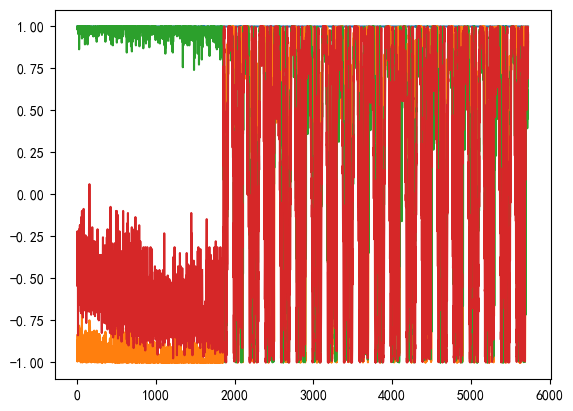

In [7]:
plt.plot(PDOA)

In [8]:
# 插补丢失的测量值
PDOA_interp = [None]*PDOA.shape[1]
rolling_interp = np.arange(rolling[0],rolling[-1]+1,1)
for i in range(PDOA.shape[1]):
    PDOA_interp[i] = np.interp(
        rolling_interp,
        rolling[np.isfinite(PDOA[:,i])],
        PDOA[np.isfinite(PDOA[:,i]),i],
    )[None,:]
PDOA_interp=np.concatenate(PDOA_interp,0).T

1857


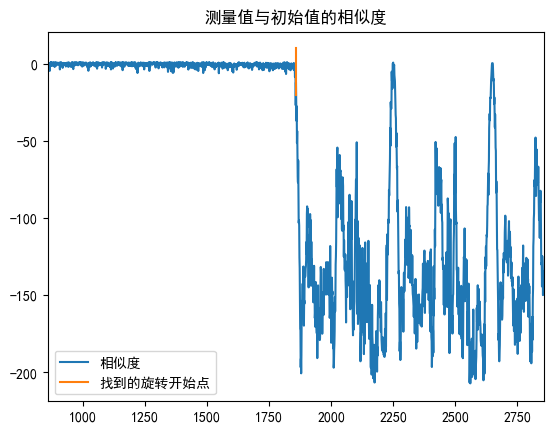

In [9]:
# 找出转台开始运动的点
pdoa_static = np.mean(PDOA_interp[:1000,:],0);
temp = np.abs(PDOA_interp@np.conj(pdoa_static))
temp=temp-np.mean(temp[:1000])
temp=temp/np.std(temp[:1000])
first_10sigma=np.where(temp<-10)[0][0]
first_20sigma=np.where(temp<-20)[0][0]
startpoint = first_10sigma - (first_20sigma-first_10sigma);
print(startpoint)
plt.plot(temp)
plt.plot([startpoint,startpoint],[-20,10])
plt.title('测量值与初始值的相似度') 
plt.xlim([startpoint-1000,startpoint+1000])
plt.legend(['相似度','找到的旋转开始点'])

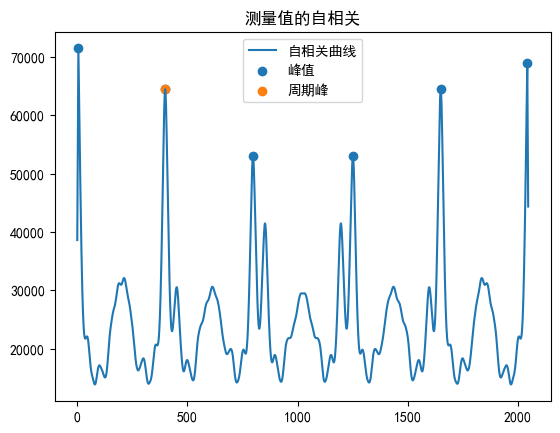

In [10]:
# 检测旋转的周期
pdoa_rotate = PDOA_interp[startpoint:,:];
fftsize = int(2**np.floor(np.log2(pdoa_rotate.shape[0])));
pdoa_rotate=pdoa_rotate[:fftsize,:]
temp = np.fft.fft(pdoa_rotate,fftsize,0);
temp = np.sum(np.abs(temp)**2,axis=1);
pdoa_corr = abs(np.fft.ifft(temp,axis=0));
pdoa_corr=np.convolve(pdoa_corr,np.ones(10),'same');
sigma = np.mean(pdoa_corr**2)**0.5;
peaks = np.where(np.all(np.array([pdoa_corr[1:-1] > pdoa_corr[:-2] , 
        pdoa_corr[1:-1] > pdoa_corr[2:] ,
        pdoa_corr[1:-1] > 2*sigma]),0))[0]+1
plt.plot(pdoa_corr)
plt.scatter(peaks,pdoa_corr[peaks])
Interval = peaks[1];
plt.scatter([Interval],pdoa_corr[Interval])
plt.title('测量值的自相关')
plt.legend(['自相关曲线','峰值','周期峰'])

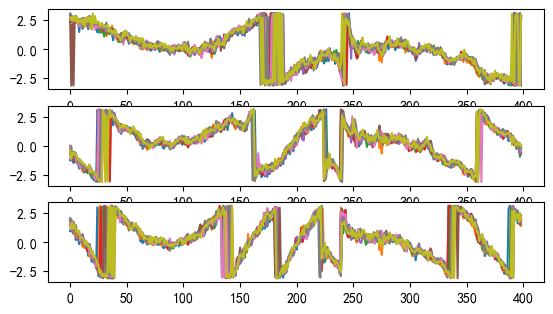

In [11]:
# 按周期合并测量数据
pdoa_rotate = PDOA_interp[startpoint:,:];
k=int(np.floor(len(pdoa_rotate)/Interval));
pdoa_rotate=pdoa_rotate[:k*Interval,:]
pdoa_rotate=np.reshape(pdoa_rotate,(k,Interval,-1),order='c')
# 转速不均匀补偿
a=np.fft.fft(pdoa_rotate[0,...],axis=0)[None,...];
b=np.fft.fft(pdoa_rotate,axis=1);
b=np.sum(a*np.conj(b),axis=2)
b=np.abs(np.fft.ifft(b,axis=1))
b=[np.argmax(b[i,:]) for i in range(b.shape[0])]
pdoa_rotate=np.concatenate([np.roll(pdoa_rotate[i,:,:],b[i],0)[None,...] for i in range(pdoa_rotate.shape[0])],0)

for j in range(1,pdoa_rotate.shape[-1]):
    plt.subplot(pdoa_rotate.shape[-1],1,j)
    for i in range(pdoa_rotate.shape[0]):
        plt.plot(np.angle(pdoa_rotate[i,:,j]))
pdoa_rotate = np.mean(pdoa_rotate,0)

In [12]:
RotationIsClockwise = False
AngleRange = 150

In [13]:
# 拟合曲线 计算校准值
# 获取相邻天线两两之间的相位差
X=np.linspace(0,360,pdoa_rotate.shape[0]);
if RotationIsClockwise:
    X=360-X;
pdoa_cal = pdoa_rotate[:,1:]+np.nan
for i in range(1,pdoa_rotate.shape[1]):
    pdoa_cal[:,i-1] = pdoa_rotate[:,i] * np.conj(pdoa_rotate[:,i-1])
    pdoa_cal[:,i-1] = pdoa_cal[:,i-1] / np.abs(pdoa_cal[:,i-1])
pdoa_cal_inRange = pdoa_cal+np.nan;
pdoa_cal_inRange[np.abs(np.mod(X+180,360)-180) < AngleRange/2,:]=pdoa_cal[np.abs(np.mod(X+180,360)-180) < AngleRange/2,:];

Text(0.5, 1.0, '平均误差:17.5°')

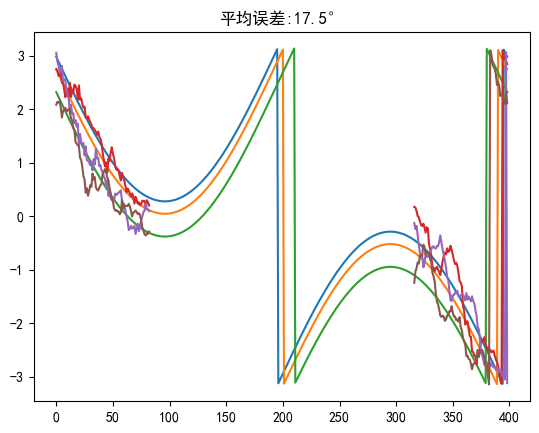

In [14]:

def optfun( theta,k,b,  pdoa_cal,RotationIsClockwise,plot=False):
    # theta,k,b为校准方程里的参数
    # N为天线序号
    Interval = pdoa_cal.shape[0];
    X=np.linspace(0,2*np.pi,Interval);
    if RotationIsClockwise:
        X=2*np.pi-X;
    Y_hat = np.exp(2j *np.pi* (k*np.sin(X[:,None]+theta)+b[None,:]));
    error = np.nanmean(np.abs(Y_hat-pdoa_cal));
    if plot:
        plt.plot(np.angle(Y_hat))
        plt.plot(np.angle(pdoa_cal))
        return np.nanmean((np.mod(np.angle(Y_hat) - np.angle(pdoa_cal) + np.pi,2*np.pi)-np.pi)**2)**0.5
    return error
from scipy.optimize import differential_evolution
# 使用 lambda 表达式创建包装函数
wrapper = lambda x: optfun(x[0],ElectLen /(3e11/Freq), x[1:4], pdoa_cal_inRange, RotationIsClockwise)
bounds = np.array([(0,2*np.pi)]+ [(0, 2*np.pi)] * 3)
result = differential_evolution(wrapper, bounds,popsize =100)
result = result.x
error = optfun(result[0], ElectLen /(3e11/Freq), result[1:4], pdoa_cal_inRange, RotationIsClockwise,plot=True)
plt.title("平均误差:%.1f°"%(error*180/np.pi))

In [17]:
PhaseOffset = np.mod(180+np.cumsum(-result[2:5]*180/np.pi),360)-180;
PhaseOffset=np.concatenate([[0],PhaseOffset],0)

PhaseOffset,ElectLen

(array([  0.        , 104.31472516, 155.21100862]), 21)

In [15]:
result[2:5]

array([4.46254989, 5.39487758])

In [18]:

PDOA_CAL = PDOA * np.exp(1j*np.pi/180 * np.array(PhaseOffset)[None,...])
pdoa = abs(np.fft.fft(PDOA_CAL,1024,axis=1));
for i in range(pdoa.shape[1]):
    pdoa[np.isfinite(pdoa[:,i]),i] = np.convolve(pdoa[np.isfinite(pdoa[:,i]),i],np.ones(21,),'same');
pdoa = pdoa[np.all(np.isfinite(pdoa),1),:]
plt.imshow(pdoa)
plt.ylim([startpoint-3*Interval,startpoint+3*Interval])
plt.show()
aoa=np.mod(0.5+np.argmax(pdoa,1)/1024,1)-0.5;
aoa = aoa / (ElectLen /(3e11/Freq));
aoa[np.abs(aoa)>1]=aoa[np.abs(aoa)>1]/np.abs(aoa[np.abs(aoa)>1]); # 限幅到-1~1
aoa_cal = np.arcsin(aoa)*180/np.pi;
ZeroPoint = -np.mean(aoa_cal[:startpoint],0)
aoa_cal = np.arcsin(np.sin((aoa_cal + ZeroPoint)*np.pi/180))*180/np.pi;
plt.plot(aoa_cal)
plt.title("PDOA angle")
plt.xlim([startpoint-3*Interval,startpoint+3*Interval])
plt.show()

ValueError: operands could not be broadcast together with shapes (5726,4) (1,3) 

In [19]:
print(f"""校准值:
AntennaDistance_mm={ElectLen:.1f}
PDOAGroups[][2]={ZeroPoint:.1f}
PDOACalibValue = 
	"{Anchors[0]}" : {PhaseOffset[0]:.1f}
	"{Anchors[1]}" : {PhaseOffset[1]:.1f}
	"{Anchors[2]}" : {PhaseOffset[2]:.1f}
	"{Anchors[3]}" : {PhaseOffset[3]:.1f}
""")

NameError: name 'ZeroPoint' is not defined